Codigo para analise de empregados no setor de serviço

In [94]:
#bibliotecas
import pandas as pd
import numpy as np
import pycaged
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sidrapy import get_table
import sidrapy
import statsmodels.api as sm
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

                           NC                 NN                          MC  \
0  Nível Territorial (Código)  Nível Territorial  Unidade de Medida (Código)   
1                           1             Brasil                        1020   
2                           1             Brasil                        1020   
3                           1             Brasil                        1020   
4                           1             Brasil                        1020   

                  MN      V              D1C     D1N                D2C  \
0  Unidade de Medida  Valor  Brasil (Código)  Brasil  Variável (Código)   
1           Unidades   8833                1  Brasil               2585   
2           Unidades   9464                1  Brasil               2585   
3           Unidades  10246                1  Brasil               2585   
4           Unidades  11319                1  Brasil               2585   

                                        D2N           D3C   D3N  \
0

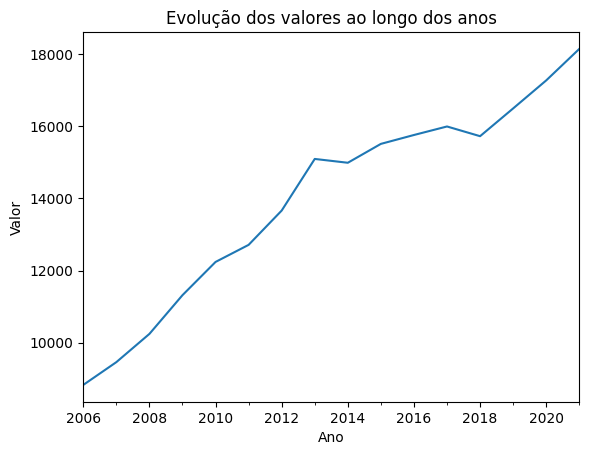

In [ ]:

# Definindo a URL da API
url = "https://apisidra.ibge.gov.br/values/t/6449/n1/all/v/2585/p/all/c12762/117756"

# Requisição GET para obter os dados
response = requests.get(url)
data = response.json()

# Convertendo os dados para um DataFrame
df = pd.DataFrame(data)

# Exibindo as primeiras linhas do DataFrame para verificar a estrutura dos dados
print(df.head())

# Selecionando apenas as colunas 'D3N' (ano) e 'V' (valor)
df = df[['D3N', 'V']]

# Renomeando as colunas para 'ano' e 'valor'
df.columns = ['ano', 'valor']

# Filtrando as linhas onde o valor da coluna 'ano' não é "Ano"
df = df[df['ano'] != 'Ano']

# Convertendo a coluna 'ano' para o formato datetime
df['ano'] = pd.to_datetime(df['ano'], format='%Y')

# Convertendo a coluna 'valor' para numérico (forçando erro se não for numérico)
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')

# Removendo linhas onde o valor não pôde ser convertido para numérico
df = df.dropna(subset=['valor'])

# Ordenando os dados por ano
df = df.sort_values('ano')

# Exibindo o gráfico da evolução dos valores ao longo dos anos
df.set_index('ano')['valor'].plot()
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Evolução dos valores ao longo dos anos')
plt.show()



p-value: 0.40767289225125847
A série não é estacionária, aplicando diferenciação.


/home/foxbologna/Documents/Projetos/FM/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/foxbologna/Documents/Projetos/FM/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/foxbologna/Documents/Projetos/FM/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             valor_diff   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -106.474
Date:                Wed, 20 Nov 2024   AIC                            218.948
Time:                        13:46:08   BIC                            220.866
Sample:                    01-01-2007   HQIC                           218.771
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1773      0.289      0.613      0.540      -0.390       0.744
ma.L1         -0.9994      0.416     -2.404      0.016      -1.814      -0.185
sigma2      2.014e+05   2.09e-06   9.65e+10      0.0

/tmp/ipykernel_4700/1925495665.py:32: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='A')[1:]


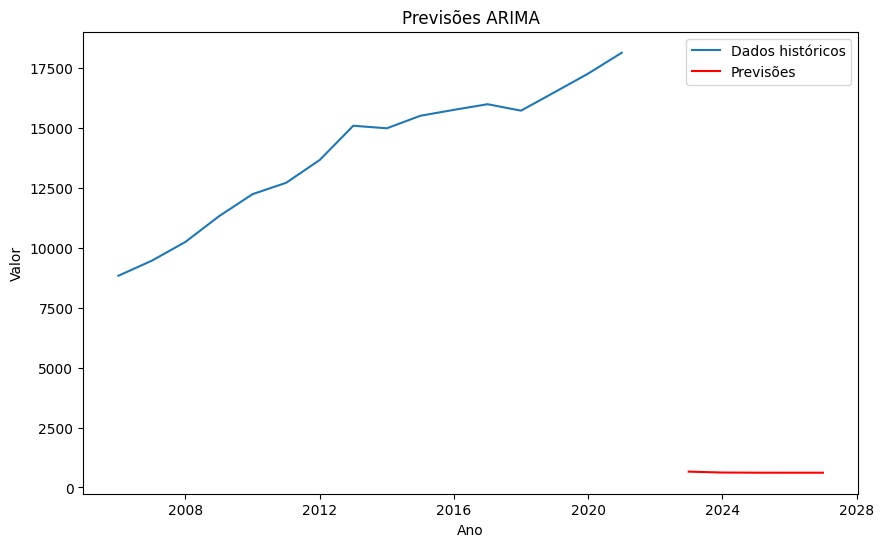

Erro Quadrático Médio (RMSE): 13606.312378530032


In [95]:
# Definindo o índice como o ano para análise de séries temporais
df.set_index('ano', inplace=True)

# 1. Análise de Estacionariedade (Teste de Dickey-Fuller)
result = adfuller(df['valor'])
print(f'p-value: {result[1]}')

# Se p-value for maior que 0.05, a série não é estacionária e precisa ser diferenciada
if result[1] > 0.05:
    print("A série não é estacionária, aplicando diferenciação.")
    df['valor_diff'] = df['valor'].diff().dropna()
else:
    print("A série é estacionária.")

# 2. Ajuste automático do modelo ARIMA
# Ajustando manualmente o modelo ARIMA (porque o auto_arima do pmdarima não é usado aqui)
# Você pode tentar ajustar a ordem conforme necessário (p, d, q)
model = ARIMA(df['valor_diff'].dropna(), order=(1, 1, 1))  # Exemplo de (p, d, q)
model_fit = model.fit()

# Exibindo o resumo do modelo
print(model_fit.summary())

# 3. Ajustando o modelo ARIMA com os parâmetros encontrados
# Aqui, o modelo já foi ajustado, então vamos usar esse ajuste para previsões

# 4. Fazendo previsões para os próximos 5 anos
forecast_steps = 5  # Número de passos para previsão
forecast = model_fit.forecast(steps=forecast_steps)

# Gerando o índice para as previsões
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='A')[1:]

# Plotando as previsões
plt.figure(figsize=(10,6))
plt.plot(df.index, df['valor'], label='Dados históricos')
plt.plot(forecast_index, forecast, label='Previsões', color='red')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Previsões ARIMA')
plt.legend()
plt.show()

# 5. Calculando o erro do modelo (exemplo com RMSE)
# Calculando o erro entre os valores previstos e os reais
predicted_values = model_fit.predict(start=0, end=len(df) - 1)
rmse = np.sqrt(mean_squared_error(df['valor'].dropna(), predicted_values))
print(f"Erro Quadrático Médio (RMSE): {rmse}")


In [96]:
# Verificando estacionariedade novamente após a diferenciação
adf_test = adfuller(df['valor_diff'].dropna())
print(f'p-value após a diferenciação: {adf_test[1]}')


p-value após a diferenciação: 0.03073617368088065


/home/foxbologna/Documents/Projetos/FM/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/foxbologna/Documents/Projetos/FM/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/foxbologna/Documents/Projetos/FM/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/foxbologna/Documents/Projetos/FM/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seaso

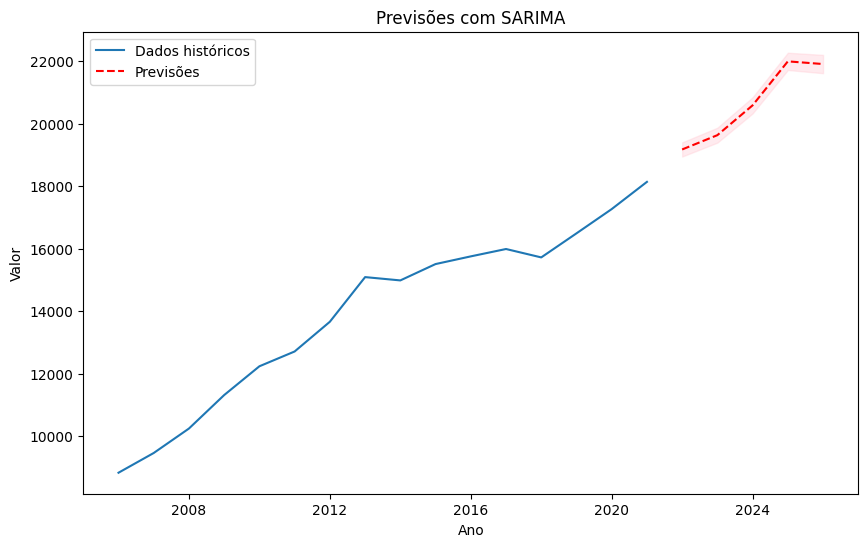

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustando o modelo SARIMA com os melhores parâmetros encontrados
sarima_opt_model = SARIMAX(df['valor'], 
                           order=(1, 1, 1),  # Ajuste esses valores com base no seu melhor modelo
                           seasonal_order=(1, 1, 1, 12))  # '12' é exemplo; ajuste para a periodicidade dos seus dados
sarima_opt_fit = sarima_opt_model.fit(disp=False)

# Previsões com o modelo ajustado
forecast_steps = 5
forecast = sarima_opt_fit.get_forecast(steps=forecast_steps)
forecast_conf_int = forecast.conf_int()

# Plotando as previsões
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['valor'], label='Dados históricos')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Previsões', color='red',linestyle='--')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Previsões com SARIMA')
plt.legend()
plt.show()


In [99]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df['valor'].dropna(), sarima_opt_fit.predict(start=0, end=len(df)-1))
print(f"Erro Absoluto Médio (MAE): {mae}")


Erro Absoluto Médio (MAE): 1321.9784230641499
